# 4) TBWGAN Analysis:

Here, we will evaluate the WGANGP training for tuberculose class.

In [2]:
import pandas as pd
import numpy as np
import json
import glob
import matplotlib.pyplot as plt
from rxwgan.models import Generator_v1
from rxcore.stats import calculate_divergences, calculate_l1_and_l2_norm_errors
from rxcore.stratified_kfold import stratified_train_val_test_splits

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from pprint import pprint
import tensorflow as tf
import os
import atlas_mpl_style as ampl
ampl.use_atlas_style()

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

## 3.1) Load files:

In [3]:
test = 0

In [4]:
tuning_path = '/home/jodafons/public/brics_models/Shenzhen/tasks/user.jodafons.task.Shenzhen.wgangp.v1_tb.test_*/**/**/'
data_path = '/home/jodafons/public/brics_data/Shenzhen/raw/Shenzhen_table_from_raw.csv'
output_path = 'output/tunings/tb/test_{test}_sort_{sort}'

In [5]:
my_df = pd.read_csv(data_path)

### Special functions:

In [8]:


def create_table(basepath):
    
    keys = ['train_critic_loss', 'train_gen_loss', 'train_reg_loss', 'train_kl_rr', 
        'train_kl_rf', 'train_js_rr', 'train_js_rf', 'train_l1_rr', 'train_l1_rf', 
        'train_l2_rr', 'train_l2_rf', 'val_critic_loss', 'val_gen_loss', 'val_kl_rr', 
        'val_kl_rf', 'val_js_rr', 'val_js_rf', 'val_l1_rr', 'val_l1_rf', 'val_l2_rr', 
        'val_l2_rf']
    
    dataframe = {}
    dataframe['test']=[]
    dataframe['sort']=[]
    #dataframe['init']=[]
    dataframe['target']=[]
    for key in keys:
        dataframe[key]=[]
    dataframe['gen_path']=[]
    dataframe['critic_path']=[]
    dataframe['hist_path']=[] 
    
    
    for path in glob.glob(basepath, recursive=False):
        info = history = json.load(open(path+'checkpoint.json'))
        dataframe['test'].append(info['test'])
        dataframe['sort'].append(info['sort'])
        dataframe['target'].append(info['target'])
    
        dataframe['hist_path'].append(path+'history.json')
        dataframe['gen_path'].append(path+'generator_trained.h5')
        dataframe['critic_path'].append(path+'critic_trained.h5')

        history = json.load(open(path+'history.json'))
        for key in keys:
            dataframe[key].append(history[key][-1])
                
    #for k in dataframe.keys():
    #    print( '%s - %d'%(k,len(dataframe[k])))
    return pd.DataFrame(dataframe)

def get_values( hs, key ):
    return np.array([h[key] for h in hs])

def load_images( df, height, width , tot=None):
    # image generator
    datagen = ImageDataGenerator( rescale=1./255 )
    generator = datagen.flow_from_dataframe(df, directory = None,
                            x_col = 'raw_image_path', 
                            y_col = 'target',
                            target_size = (height,width),
                            batch_size=1,
                            class_mode = 'raw', 
                            shuffle = False,
                            color_mode = 'grayscale')
    data = None
    for _ in range(df.shape[0] if not tot else tot):
        d, _ = generator.next()
        if data is not None:
            data = np.concatenate((data, d), axis=0)
        else:
            data=d
    return data

def display_images(fake_samples):
    # disp plot
    fig = plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5,5,1+i)
        plt.axis('off')
        plt.imshow(fake_samples[i],cmap='gray')
    return fig


def plot_hist( a, b , bins=100, ylim_top=None, ylim_bot=None, xlabel='', 
               colors=['black', 'tomato'], ylabel=('Count',''), density=False, 
              labels=('a','b','a/b'), alpha=0.3, ylog=False, title=None):
    
    fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(10, 9), 
                                         sharex=True, 
                                         gridspec_kw={'height_ratios' : [2.5, 1.]})
    
    if title:
        ax_top.set_title(title)
    # plot histogram centered on values 0..255
    a_pdf = ax_top.hist(a, bins=bins, histtype='step', color=colors[0], 
                             lw=1.5, label=labels[0], density=density)
    b_pdf = ax_top.hist(b, bins=bins, histtype='stepfilled', color=colors[1], alpha=alpha,
                             lw=1.5, label=labels[1], density=density)
    
    bin_edges = a_pdf[1]
    
    ax_top.set_ylabel(ylabel[0], fontsize=18, loc='top')
    if ylog:
        ax_top.set_yscale('log')
    if ylim_top:
        ax_top.set_ylim(top=y_range_top)
    ax_top.legend(loc='best', fontsize=18)
    delta = a_pdf[0] - b_pdf[0]
    ax_bot.plot(bin_edges[0: -1] + np.diff(bin_edges)/2, delta, 'o', 
                color='black', fillstyle='full', 
                )
    
    ax_bot.legend(loc='best', fontsize=18)
    ax_bot.set_xlabel(xlabel, fontsize=18, loc='right')
    ax_bot.set_ylabel(ylabel[1], fontsize=18, loc='center')
    plt.tight_layout()
    plt.show()
    return fig, ax_top, ax_bot

## 3.2) Load tunings:

We will check the values for all 10 sorts.

In [9]:
cv_df = create_table(tuning_path)
cv_df.head()

,test,sort,target,train_critic_loss,train_gen_loss,train_reg_loss,train_kl_rr,train_kl_rf,train_js_rr,train_js_rf,...,val_kl_rf,val_js_rr,val_js_rf,val_l1_rr,val_l1_rf,val_l2_rr,val_l2_rf,gen_path,critic_path,hist_path
0,0,0,1,-2.109540,1.331019,0.083451,0.249089,0.232922,0.050537,0.049959,...,0.208416,0.046804,0.044463,0.146269,0.152134,0.043755,0.046810,/home/jodafons/public/brics_models/Shenzhen/ta...,/home/jodafons/public/brics_models/Shenzhen/ta...,/home/jodafons/public/brics_models/Shenzhen/ta...
1,0,1,1,-1.878339,-1.392173,0.093881,0.249448,0.200021,0.050620,0.046052,...,0.200210,0.051768,0.046331,0.148378,0.149648,0.043848,0.044574,/home/jodafons/public/brics_models/Shenzhen/ta...,/home/jodafons/public/brics_models/Shenzhen/ta...,/home/jodafons/public/brics_models/Shenzhen/ta...
2,0,2,1,-1.989363,3.357702,0.100251,0.247028,0.220314,0.050388,0.049698,...,0.196395,0.047467,0.045613,0.143299,0.144925,0.041832,0.042090,/home/jodafons/public/brics_models/Shenzhen/ta...,/home/jodafons/public/brics_models/Shenzhen/ta...,/home/jodafons/public/brics_models/Shenzhen/ta...
3,0,3,1,-2.020193,-0.827310,0.092902,0.242068,0.232982,0.049471,0.051080,...,0.249247,0.057066,0.051861,0.151837,0.151126,0.046403,0.045522,/home/jodafons/public/brics_models/Shenzhen/ta...,/home/jodafons/public/brics_models/Shenzhen/ta...,/home/jodafons/public/brics_models/Shenzhen/ta...
4,0,4,1,-2.136040,-1.232759,0.114251,0.250966,0.208208,0.051015,0.047359,...,0.207746,0.041435,0.044689,0.147438,0.150696,0.044230,0.045628,/home/jodafons/public/brics_models/Shenzhen/ta...,/home/jodafons/public/brics_models/Shenzhen/ta...,/home/jodafons/public/brics_models/Shenzhen/ta...


In [11]:
cv_df_test = cv_df.loc[cv_df.test==test]

Get the model with the lowest KL between real and fake images

In [12]:
best_sort = cv_df_test['val_kl_rf'].idxmin()
print(best_sort)
# open all histories for each sort
history_per_cv = [ json.load(open(cv_df_test['hist_path'].values[sort])) for sort in range(10) ]
epochs = list(range(len(history_per_cv[0]['train_gen_loss'])))

2


In [13]:
output_path = output_path.format(test=test,sort=best_sort)

In [14]:
os.makedirs(output_path, exist_ok=True)

## 3.3) Check train and validation curves:

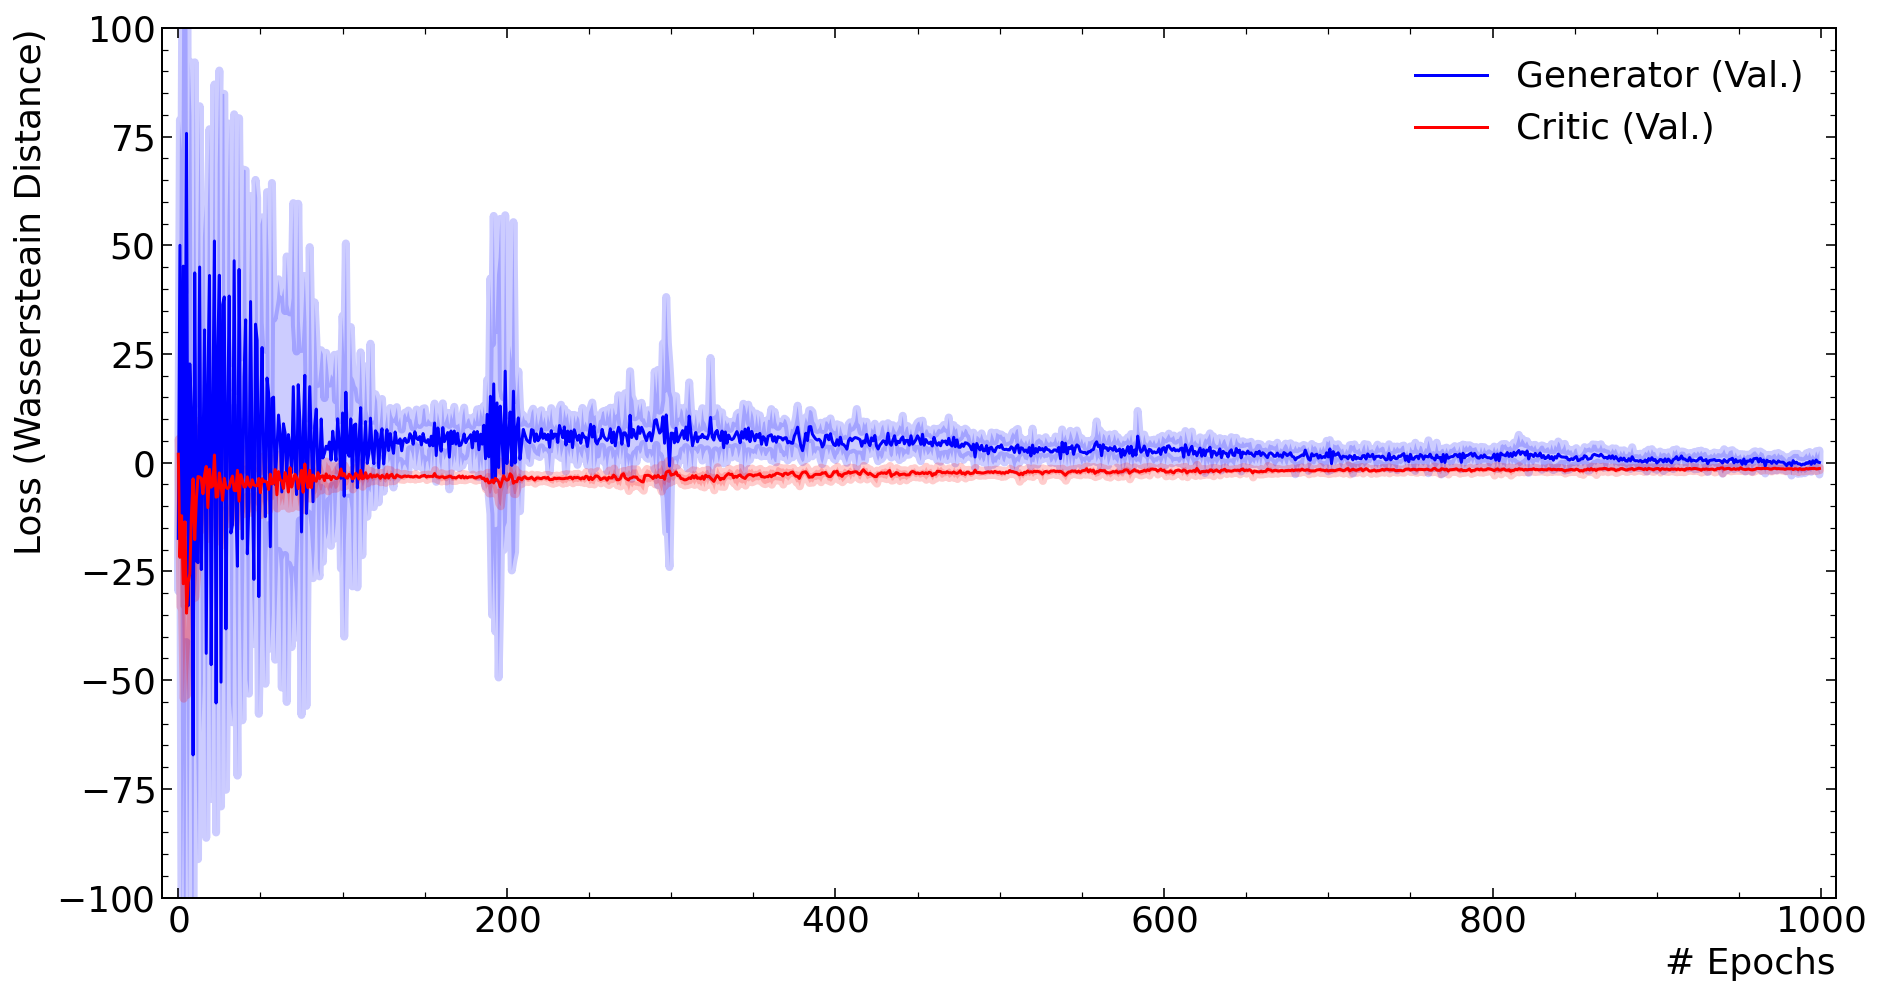

In [19]:
xmin = epochs[0]-10
xmax = epochs[-1]+10
fig = plt.figure(figsize=(15, 8))

y_gen = get_values(history_per_cv, 'val_gen_loss')
y_gen_mean = y_gen.mean(axis=0)
y_gen_std = y_gen.std(axis=0)
plt.plot( epochs, y_gen_mean, label='Generator (Val.)', color='blue')
plt.fill_between(epochs, y_gen_mean-y_gen_std, y_gen_mean+y_gen_std, alpha=0.2, antialiased=True, 
                 color='blue',linewidth=4)

y_critic = get_values(history_per_cv, 'val_critic_loss')
y_critic_mean = y_critic.mean(axis=0)
y_critic_std = y_critic.std(axis=0)
plt.plot( epochs, y_critic_mean, label='Critic (Val.)', color='red')
plt.fill_between(epochs, y_critic_mean-y_critic_std, y_critic_mean+y_critic_std, alpha=0.2, 
                 antialiased=True, color='red',linewidth=4)

plt.ylabel('Loss (Wassersteain Distance)',fontsize=18,loc='top')
plt.xlabel("# Epochs",fontsize=18,loc='right')
ax = plt.gca()
ax.set_xlim(xmin,xmax)
ax.set_ylim(-100,+100)
plt.legend()
plt.show()
fig.savefig(output_path+'/cv_val_loss.pdf')

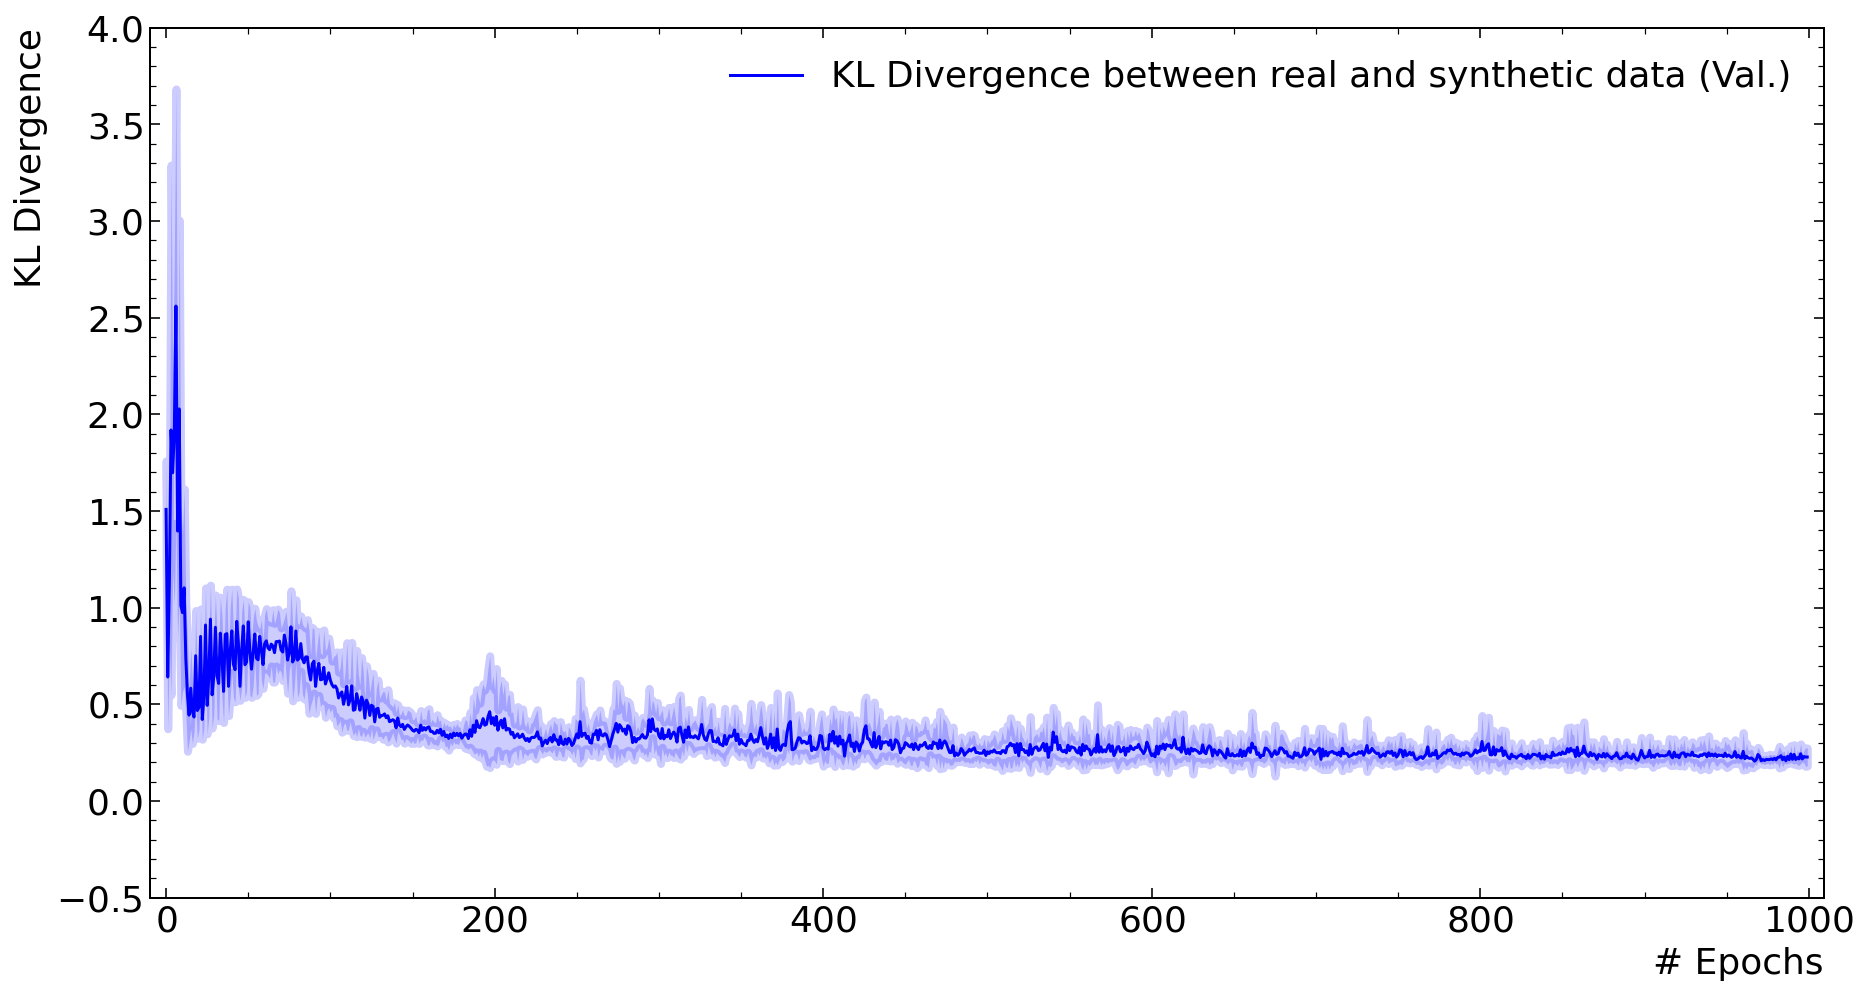

In [21]:
xmin = epochs[0]-10
xmax = epochs[-1]+10
fig = plt.figure(figsize=(15, 8))

y_gen = get_values(history_per_cv, 'val_kl_rf')
y_gen_mean = y_gen.mean(axis=0)
y_gen_std = y_gen.std(axis=0)
plt.plot( epochs, y_gen_mean, label='KL Divergence between real and synthetic data (Val.)', color='blue')
plt.fill_between(epochs, y_gen_mean-y_gen_std, y_gen_mean+y_gen_std, alpha=0.2, antialiased=True, 
                 color='blue',linewidth=4)
plt.ylabel('KL Divergence',fontsize=18,loc='top')
plt.xlabel("# Epochs",fontsize=18,loc='right')
ax = plt.gca()
ax.set_xlim(xmin,xmax)
#ax.set_ylim(0,+1.2)
plt.legend()
plt.show()
fig.savefig(output_path+'/cv_val_kl.pdf')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


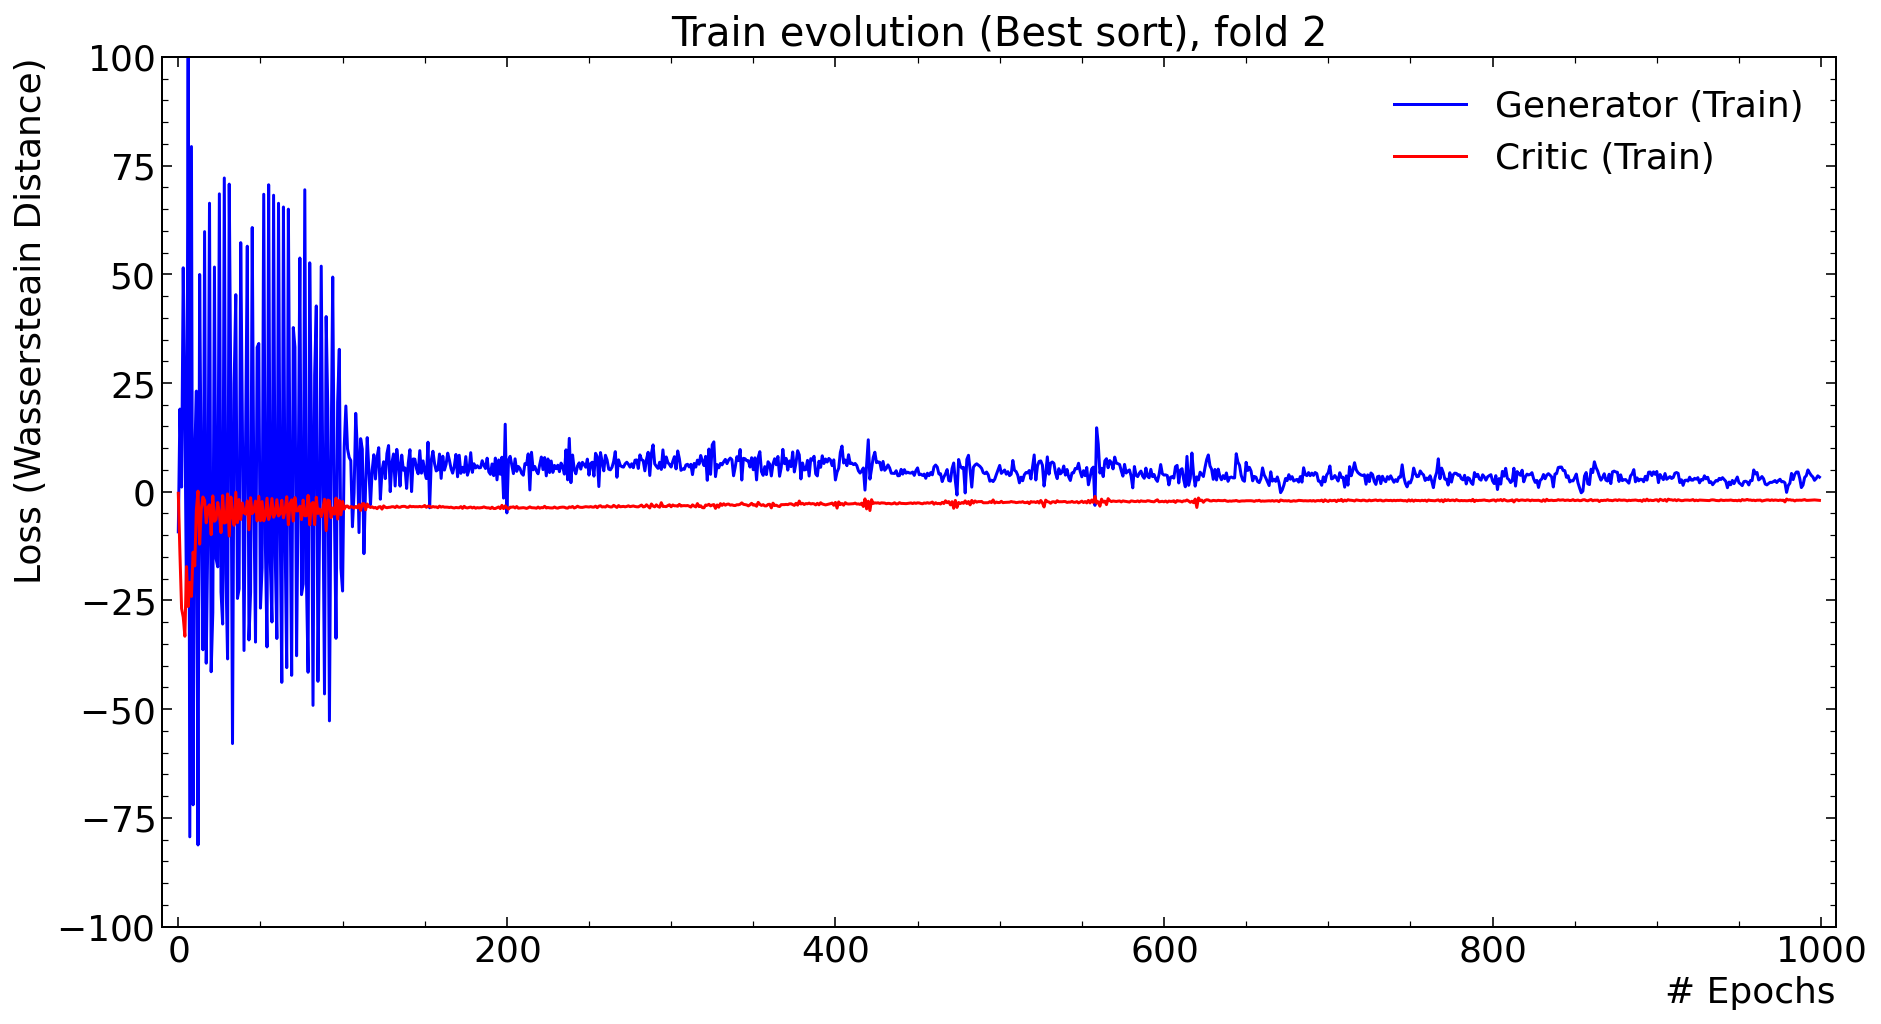

In [22]:
history = history_per_cv[best_sort]
epochs = list(range(len(history['train_gen_loss'])))
xmin = epochs[0] - 10
xmax = epochs[-1] + 10
fig = plt.figure(figsize=(15, 8))
plt.plot( epochs, history['train_gen_loss'], label='Generator (Train)', color='blue')
plt.plot( epochs, history['train_critic_loss'], label='Critic (Train)', color='red')
plt.ylabel('Loss (Wassersteain Distance)',fontsize=18,loc='top')
plt.xlabel("# Epochs",fontsize=18,loc='right')
plt.title('Train evolution (Best sort), fold %d'%best_sort)
ax = plt.gca()
ax.set_xlim(xmin,xmax)
ax.set_ylim(-100,+100)
plt.legend()
plt.show()
fig.savefig(output_path+'/best_train_loss.pdf')

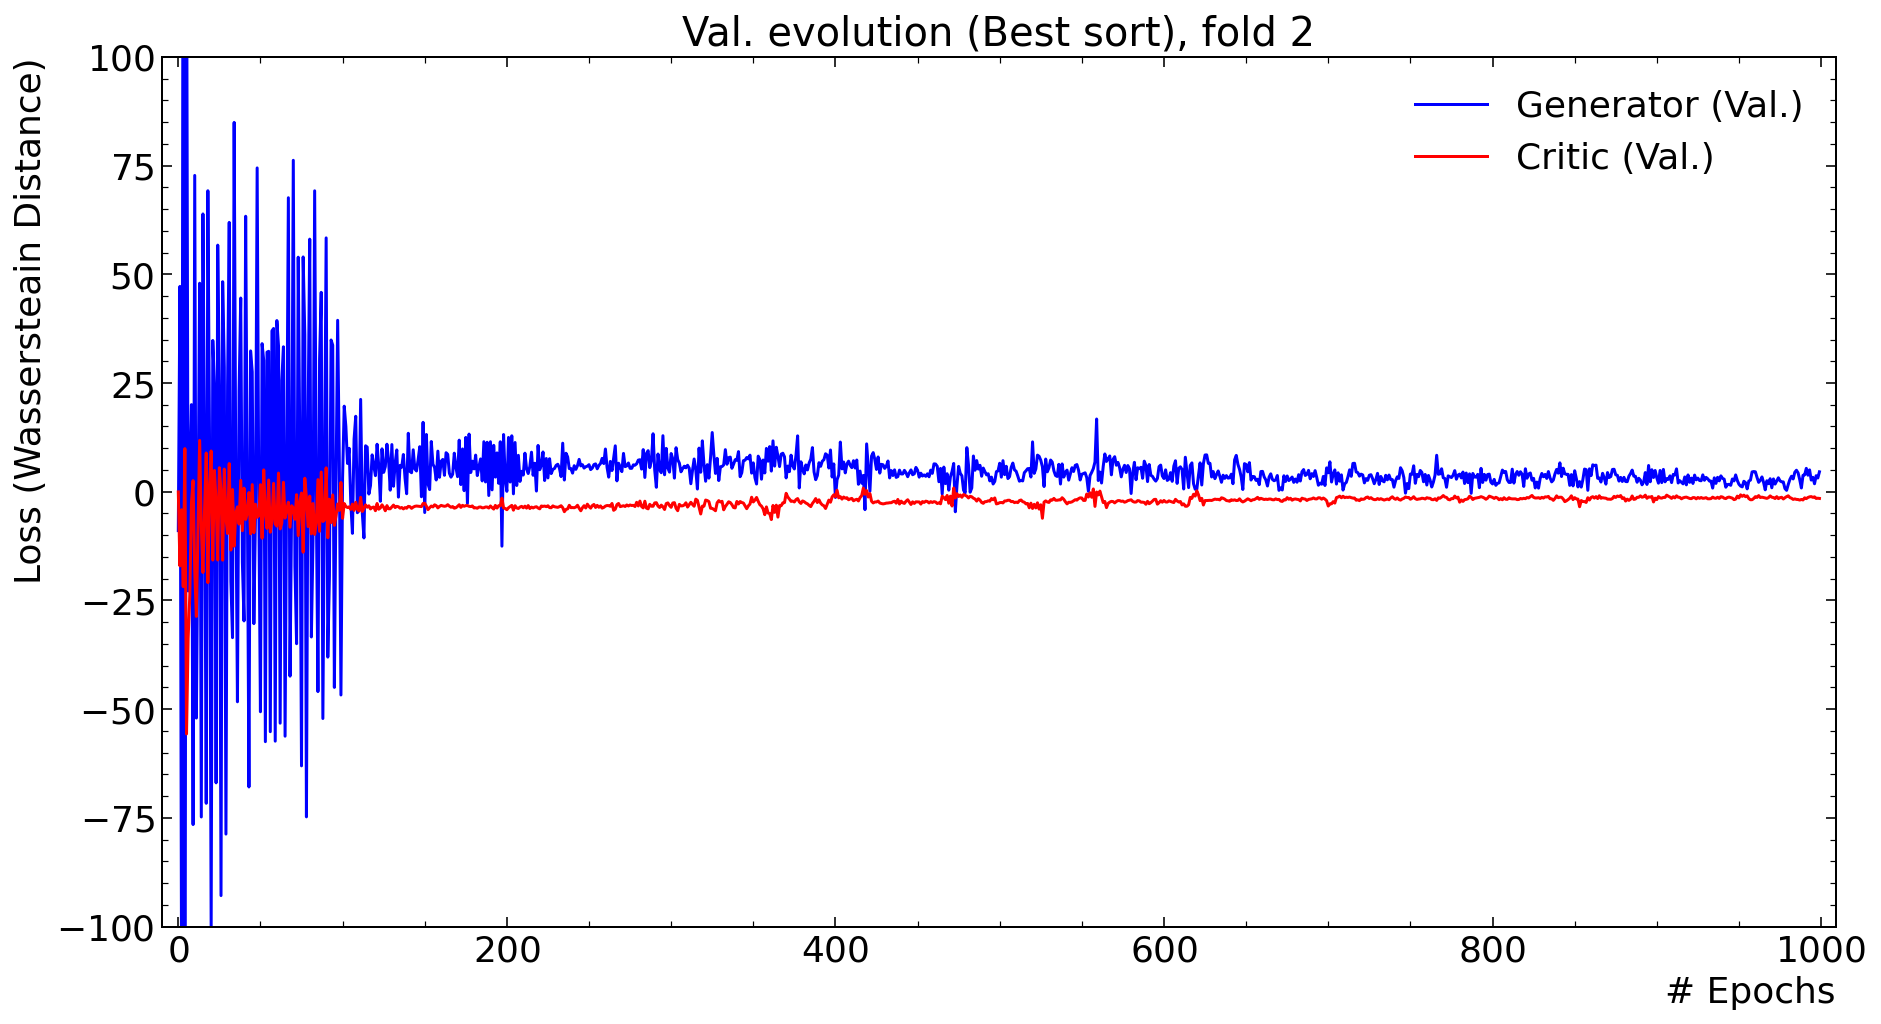

In [23]:
history = history_per_cv[best_sort]
epochs = list(range(len(history['val_gen_loss'])))
xmin = epochs[0] - 10
xmax = epochs[-1] + 10
fig = plt.figure(figsize=(15, 8))
plt.plot( epochs, history['val_gen_loss'], label='Generator (Val.)', color='blue')
plt.plot( epochs, history['val_critic_loss'], label='Critic (Val.)', color='red')
plt.ylabel('Loss (Wassersteain Distance)',fontsize=18,loc='top')
plt.xlabel("# Epochs",fontsize=18,loc='right')
plt.title('Val. evolution (Best sort), fold %d'%best_sort)
ax = plt.gca()
ax.set_xlim(xmin,xmax)
ax.set_ylim(-100,+100)
plt.legend()
plt.show()
fig.savefig(output_path+'/best_val_loss.pdf')

## 3.4) Check Real Vs Synthetic data using test set:

Recover the original test set for this task:

In [24]:
test_indexs = stratified_train_val_test_splits(my_df)[test][best_sort][2] # any sort will have the same test set

In [25]:
test_df = my_df.iloc[test_indexs]

In [26]:
test_df = test_df.loc[test_df.target==True]

Get the model:

In [27]:
gen_model = Generator_v1(cv_df_test['gen_path'].values[best_sort])

In [28]:
real_samples = load_images( test_df, gen_model.height,gen_model.width)
print(real_samples.shape)

Found 34 validated image filenames.
(34, 128, 128, 1)


In [39]:
fake_samples = gen_model.generate( real_samples.shape[0] ).numpy()
print(fake_samples.shape)

(34, 128, 128, 1)


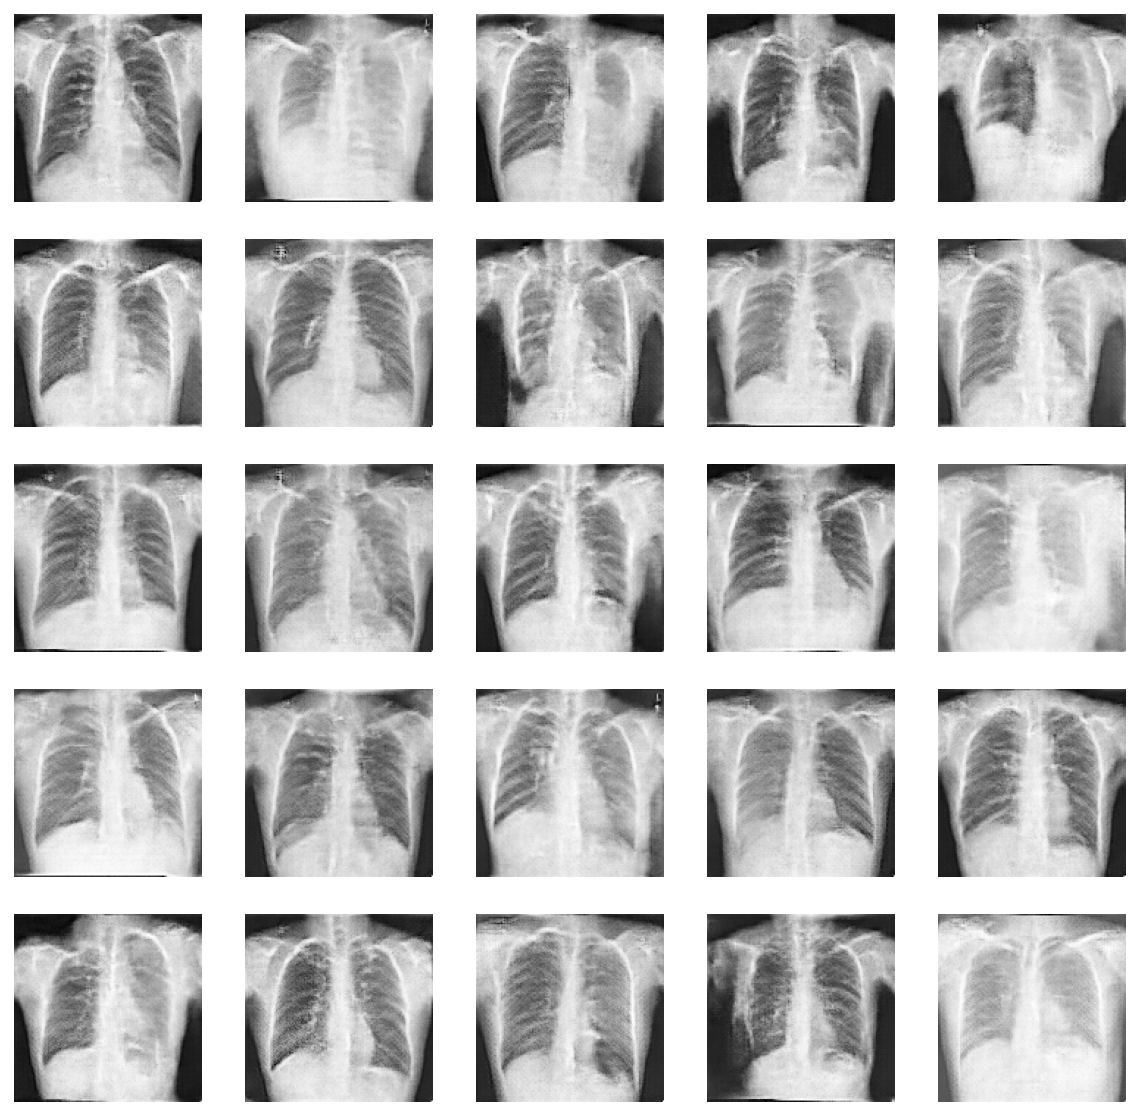

In [41]:
fig = display_images(fake_samples)
fig.show()
fig.savefig(output_path+'/fake_samples_best_model.pdf')

In [42]:
test_kl_rf, test_js_rf = calculate_divergences( real_samples, fake_samples )
test_l1_rf, test_l2_rf = calculate_l1_and_l2_norm_errors( real_samples, fake_samples )

test_kl_rr, test_js_rr = calculate_divergences( real_samples, real_samples )
test_l1_rr, test_l2_rr = calculate_l1_and_l2_norm_errors( real_samples, real_samples )

No handles with labels found to put in legend.


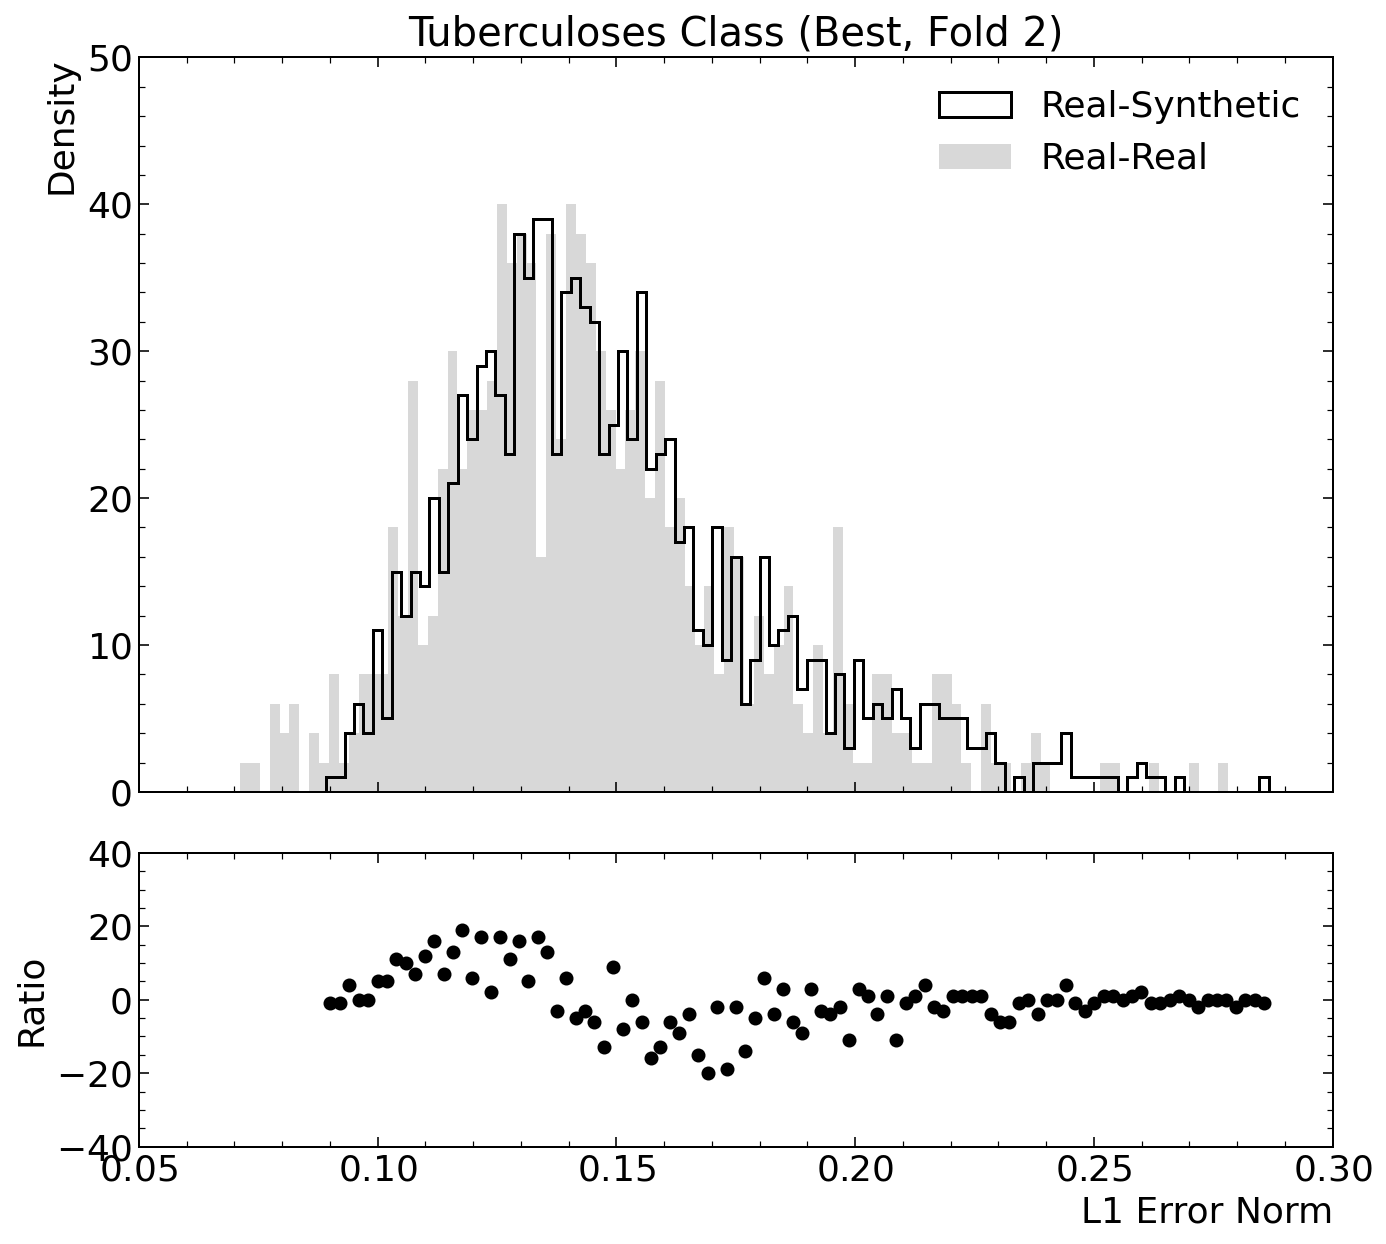

In [43]:
fig,_,_ = plot_hist( test_l1_rf, test_l1_rr , ylabel=('Density', 'Ratio'),
                     density=False, xlabel='L1 Error Norm',
                     title='Tuberculoses Class (Best, Fold %d)'%best_sort,
                     labels=('Real-Synthetic', 'Real-Real'), colors=['black', 'gray'])
fig.savefig(output_path+'/l1_norm_dist.pdf')

No handles with labels found to put in legend.


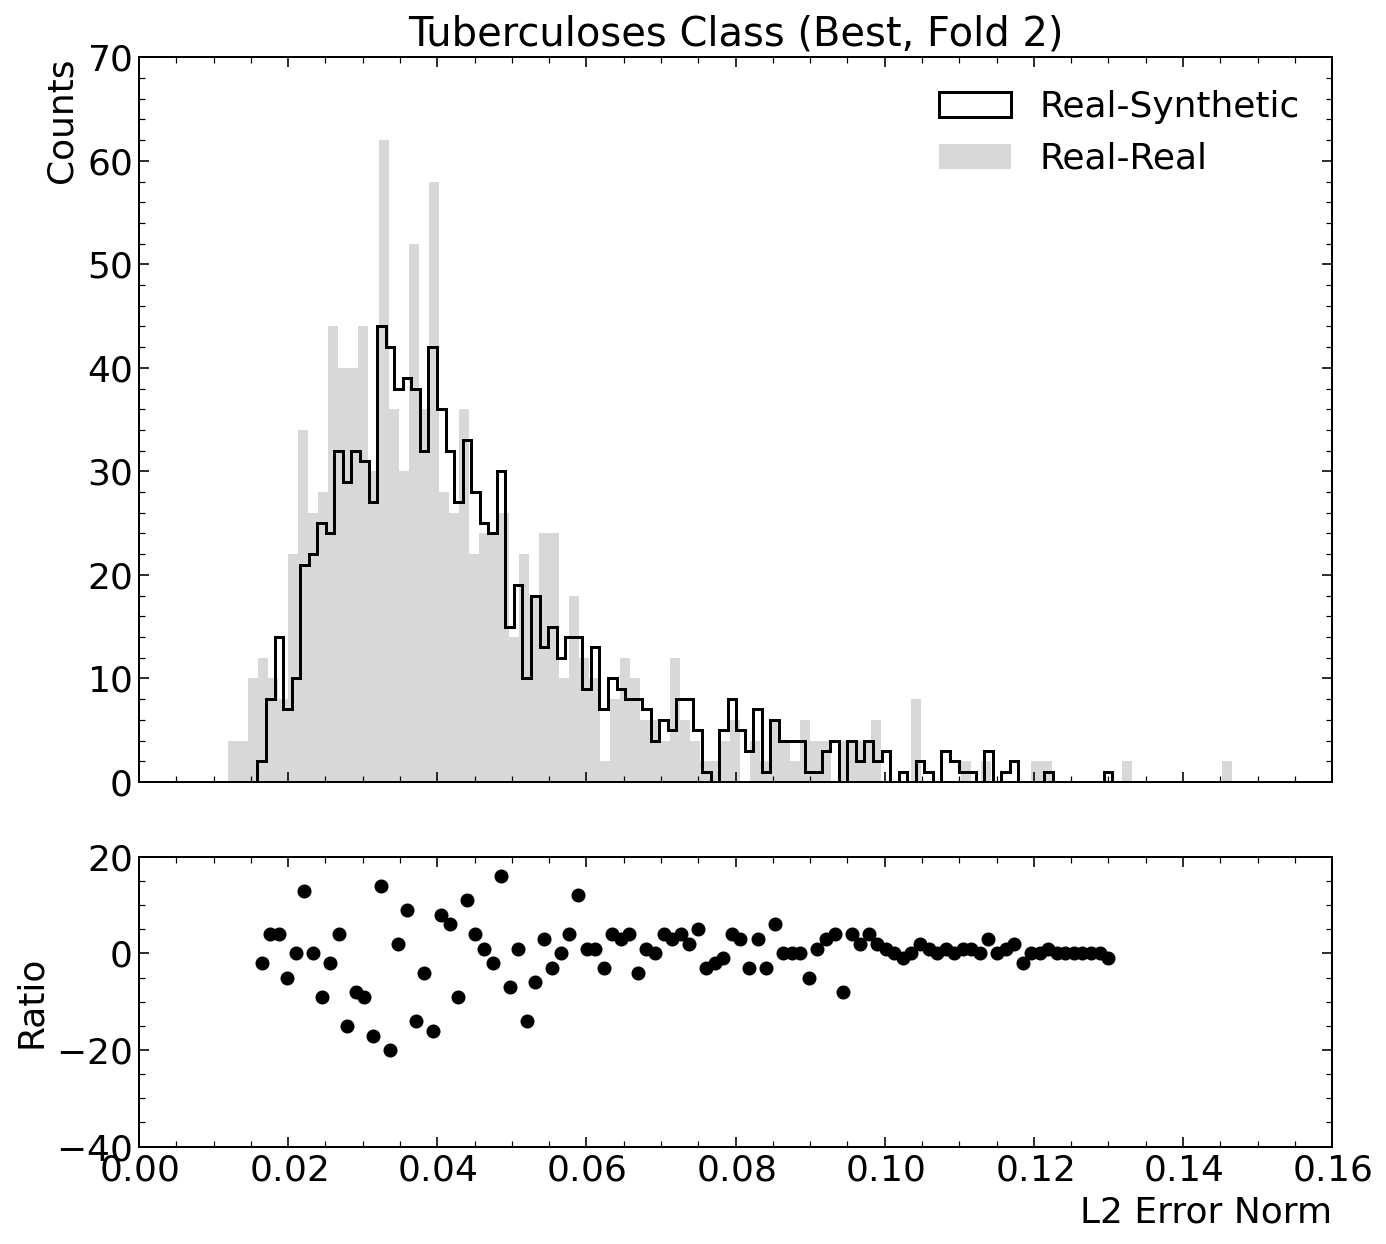

In [44]:
fig,_,_ = plot_hist( test_l2_rf, test_l2_rr , ylabel=('Counts', 'Ratio'),density=False, 
                 xlabel='L2 Error Norm',
                 title='Tuberculoses Class (Best, Fold %d)'%best_sort,
                 labels=('Real-Synthetic', 'Real-Real'), colors=['black', 'gray'])
fig.savefig(output_path+'/l2_norm_dist.pdf')

No handles with labels found to put in legend.


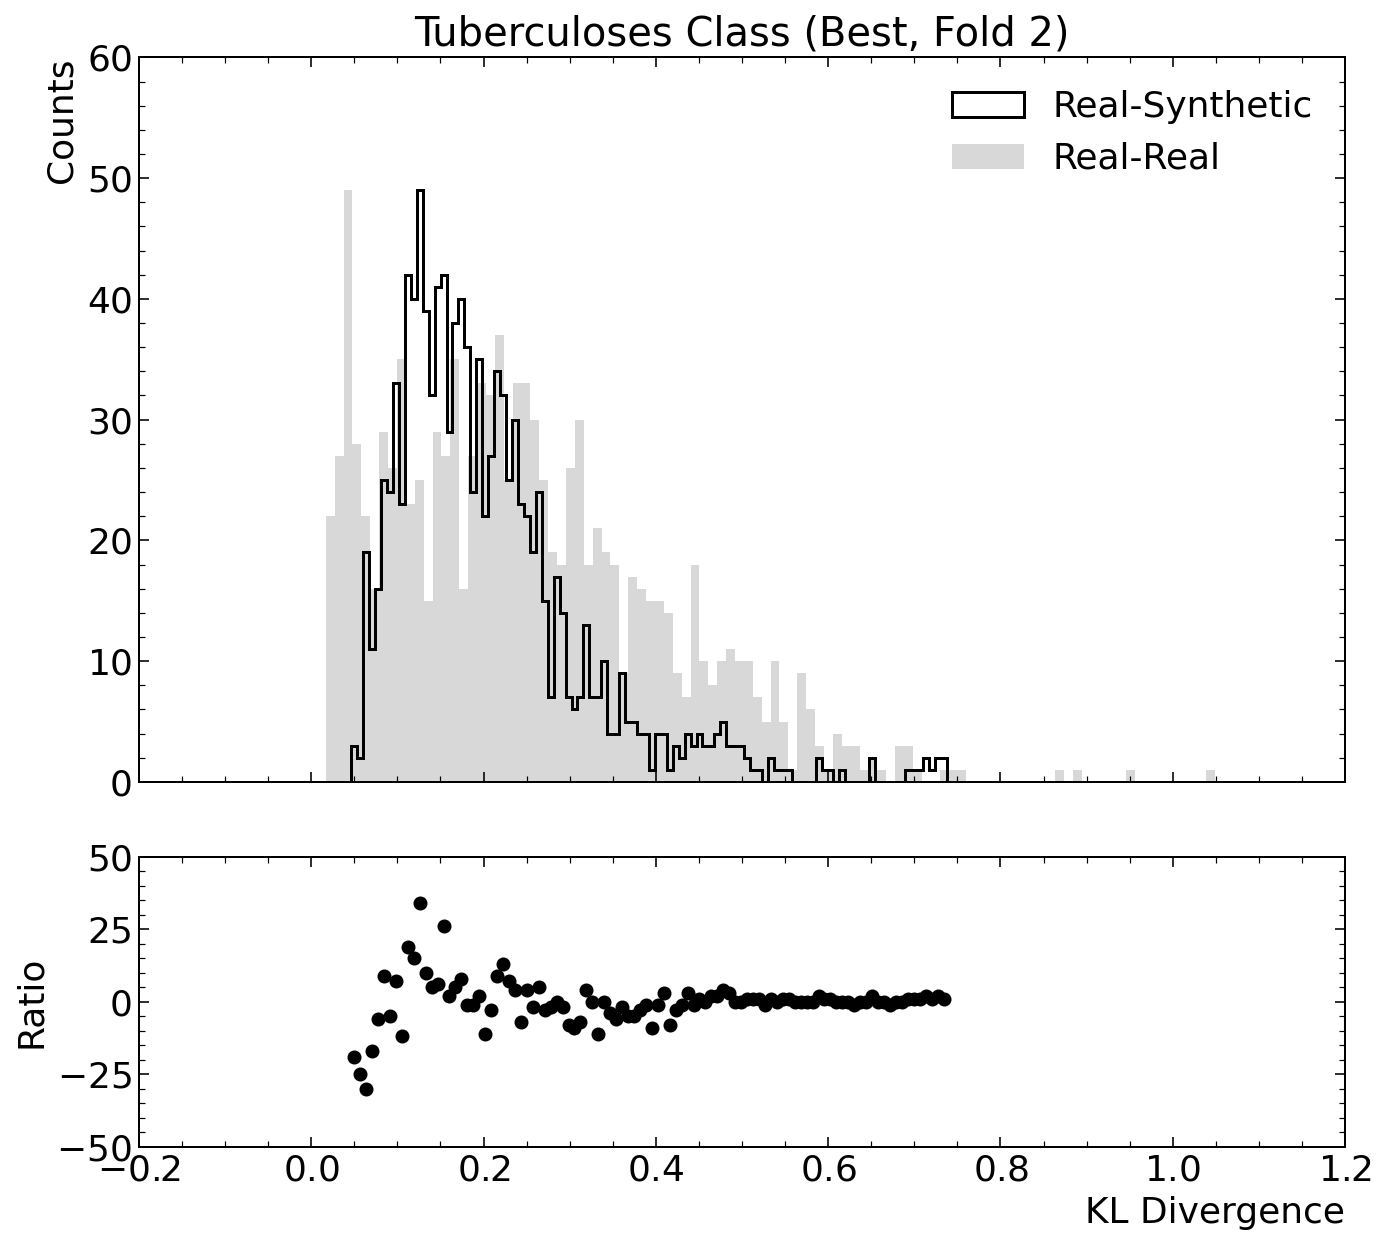

In [45]:
fig,_, _ = plot_hist( test_kl_rf, test_kl_rr , ylabel=('Counts', 'Ratio'),density=False, 
                 xlabel='KL Divergence', alpha=0.3,
                 title='Tuberculoses Class (Best, Fold %d)'%best_sort,
                 labels=('Real-Synthetic', 'Real-Real'), colors=['black', 'gray'])
fig.savefig(output_path+'/kl_divergence_dist.pdf')

### 3.5) Conclusions:

In [46]:
tpath= cv_df_test['hist_path'].values[best_sort].replace('history.json','')
os.system('cp -r %s/* %s' % (tpath, output_path) )


0